### Note: Place code in directory, with the folder for images and a folder for output files on the same level.

Version History:
- v1.0.0: Added fucntions to automatically split training, testing, and validation. Trains, tests, and gives confusion matrix, but no post-processing (e.g. attention maps)

In [70]:
# Importing modules to build, train, and test model
import os
import stat
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import matplotlib.ticker as mtick
import numpy as np
import imageio as im
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
import PIL
from PIL import Image

# Importing modules to build heatmap
from keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from keras.layers import Input
from keras import activations
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras import initializers
from keras.models import Model
import matplotlib.cm as cm
import random

from tensorflow.keras.applications import imagenet_utils
import h5py

from vis.visualization import overlay,visualize_cam,visualize_activation,visualize_saliency
from vis.utils import utils

import imageio
import time
import ntpath
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("All loaded!")

All loaded!


Importing modules to find image files, convert to usable image data, and build the CNN.
#  

In [79]:
# Clearing the memory for a fresh start and prevention of slowdown
tf.keras.backend.clear_session()

In [80]:
# Defining directories to make easier to reference later on:

cwd = os.getcwd()
training_dir = cwd + "\jpg_split\\train"
testing_dir = cwd + "\jpg_split\\test"
validation_dir = cwd + "\jpg_split\\val"
output_dir = cwd + "\output"
weights_dir = '\outputs\\boiling_weights.hdf5'
classifier_dir = cwd + "\outputs\\boiling_model.h5"
#output_dir = "/images"

In [81]:
# Creating (and downscaling) the location for the image data to be stored
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

# Setting the image/batch parameters to change easily if need be
# Certain parameters later on typically depend on these values
image_width = 128
image_height = 128
batch_size = 25

# Taking in the image data from a given directory
# The classes are automatically set based on how the folders are arranged
training_set = train_datagen.flow_from_directory(training_dir,
                                                 target_size = (image_width, image_height),
                                                 batch_size = batch_size,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(testing_dir,
                                            target_size = (image_width, image_height),
                                            batch_size = 1,
                                            shuffle=False,
                                            class_mode = 'categorical')

validation_set = val_datagen.flow_from_directory(validation_dir,
                                                 target_size = (image_width, image_height),
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode = 'categorical')

Found 9746 images belonging to 3 classes.
Found 3048 images belonging to 3 classes.
Found 2435 images belonging to 3 classes.


In [82]:
classifier = Sequential()

# Adding the first convolutional layer
classifier.add(Conv2D(32, (3, 3), padding='same', input_shape = (128, 128, 3), activation = 'relu'))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Adding a third convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # antes era 0.25

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 512, activation = 'relu'))
classifier.add(Dropout(0.5)) 
classifier.add(Dense(units = 3, activation = 'softmax', name='visualized_layer')) 
                     # Note that the units here should
                     # be equal to number of classes

In [83]:
# Simply prints an overview of the model
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)       

In [84]:
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [86]:
# Setting up a checkpoint such that after every cycle of the CNN, 
# the best parameters (weights) will be saved
checkpointer = ModelCheckpoint(filepath="cnn_boiling_1.0.0.hdf5", 
                               monitor = 'loss',
                               verbose=1, 
                               save_best_only=True)

# Prepare callback for training time.
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times=[]
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start=time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
earlystop = EarlyStopping(patience=7)
callbacks = [checkpointer, time_callback]

In [87]:
# As mentioned above, certain parameters of the model are based on ratios between the size
# of the samples, batch, etc.

# Number of epochs is kept relatively low (to run quicker and diagnose problems), 
# but can be increased for actual use later on
history = classifier.fit_generator(training_set,
                                   steps_per_epoch = math.ceil(training_set.n/training_set.batch_size),
                                   epochs = 25,
                                   callbacks=callbacks,
                                   validation_data = validation_set,
                                   validation_steps = math.ceil(validation_set.n/validation_set.batch_size),
                                   shuffle=True)

Epoch 1/25
390/390 [==============================] - 342s 877ms/step - loss: 0.2433 - accuracy: 0.9342 - val_loss: 1.1086e-06 - val_accuracy: 0.9975

Epoch 00001: loss improved from inf to 0.24326, saving model to cnn_boiling_1.0.0.hdf5
Epoch 2/25
390/390 [==============================] - 327s 839ms/step - loss: 0.0231 - accuracy: 0.9935 - val_loss: 1.1921e-08 - val_accuracy: 0.9979

Epoch 00002: loss improved from 0.24326 to 0.02308, saving model to cnn_boiling_1.0.0.hdf5
Epoch 3/25
390/390 [==============================] - 327s 838ms/step - loss: 0.0344 - accuracy: 0.9960 - val_loss: 1.2469e-05 - val_accuracy: 0.9996

Epoch 00003: loss did not improve from 0.02308
Epoch 4/25
390/390 [==============================] - 327s 838ms/step - loss: 0.0125 - accuracy: 0.9978 - val_loss: 0.0000e+00 - val_accuracy: 0.9996

Epoch 00004: loss improved from 0.02308 to 0.01253, saving model to cnn_boiling_1.0.0.hdf5
Epoch 5/25
390/390 [==============================] - 326s 837ms/step - loss: 0.

In [88]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [89]:
output_file = open(r"output_1.0.0.txt", "w")

output_file.write("loss\n")
for i in range(len(loss)):
    output_file.write(str(loss[i]))
    output_file.write("\n")
output_file.write("\nval_loss\n")
for i in range(len(val_loss)):
    output_file.write(str(val_loss[i]))
    output_file.write("\n")
output_file.write("\naccuracy\n")
for i in range(len(accuracy)):
    output_file.write(str(accuracy[i]))
    output_file.write("\n")
output_file.write("\nval_accuracy\n")
for i in range(len(val_accuracy)):
    output_file.write(str(val_accuracy[i]))
    output_file.write("\n")
    
output_file.close()

In [90]:
times = time_callback.times
print("Total time: ", np.sum(times))
print("Average time: ", np.sum(times)/len(times))

Total time:  8208.863645792007
Average time:  328.3545458316803


In [91]:
classifier.save("cnn_1.0.0.h5")

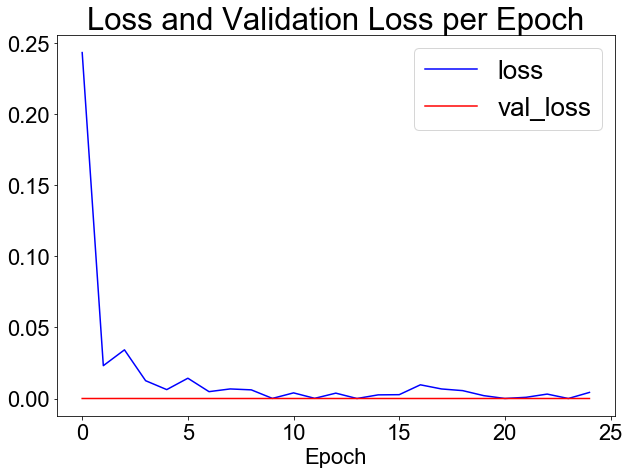

In [109]:
matplotlib.pyplot.figure(figsize=(10,7))
matplotlib.pyplot.rcParams["font.family"] = "Arial"
matplotlib.pyplot.rcParams.update({'font.size': 22})
matplotlib.pyplot.plot(history.history['loss'], label='Loss', color='blue');
matplotlib.pyplot.plot(history.history['val_loss'], label='Validation Loss', color='red');
matplotlib.pyplot.xlabel('Epoch');
matplotlib.pyplot.rcParams.update({'font.size': 26})
matplotlib.pyplot.title('Loss and Validation Loss per Epoch')
matplotlib.pyplot.legend();
matplotlib.pyplot.savefig('cnn_1.0.0_loss.png')

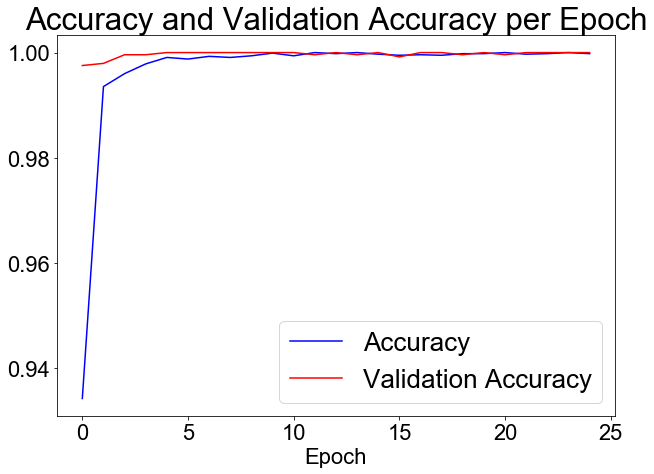

In [110]:
matplotlib.pyplot.figure(figsize=(10,7))
matplotlib.pyplot.rcParams["font.family"] = "Arial"
matplotlib.pyplot.rcParams.update({'font.size': 22})
matplotlib.pyplot.plot(history.history['accuracy'], label='Accuracy', color='blue');
matplotlib.pyplot.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red');
matplotlib.pyplot.xlabel('Epoch');
matplotlib.pyplot.rcParams.update({'font.size': 26})
matplotlib.pyplot.title('Accuracy and Validation Accuracy per Epoch')
matplotlib.pyplot.legend();
matplotlib.pyplot.savefig('cnn_1.0.0_acc.png')

In [94]:
loaded_model = load_model("cnn_1.0.0.h5")

In [95]:
filenames = test_set.filenames
nb_samples = len(filenames)

predict = classifier.predict_generator(test_set, steps = nb_samples)

In [97]:
print(predict)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
y_pred_report = np.argmax(predict, axis = 1)
y_test_report = np.argmax(y_test, axis = 1)

In [98]:
print('Classification Report')
target_names = ["class_0", "class_1", "class_2"]
print(classification_report(test_set.classes, y_pred_report, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     class_0       1.00      1.00      1.00       138
     class_1       1.00      1.00      1.00      2630
     class_2       1.00      1.00      1.00       280

    accuracy                           1.00      3048
   macro avg       1.00      1.00      1.00      3048
weighted avg       1.00      1.00      1.00      3048



In [99]:
print('Confusion Matrix')
matrix=confusion_matrix(test_set.classes, y_pred_report)
print(matrix)

Confusion Matrix
[[ 138    0    0]
 [   0 2630    0]
 [   0    0  280]]


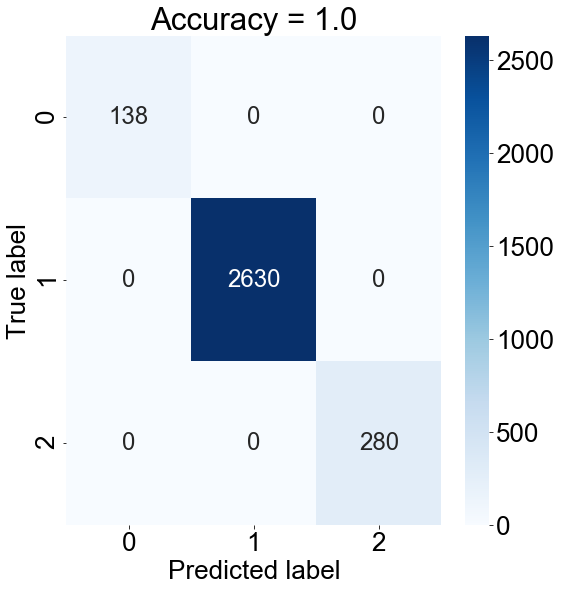

In [111]:
figure = matplotlib.pyplot.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=matplotlib.pyplot.cm.Blues,
           annot_kws={"size": 24}, fmt='d')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.title("Accuracy = 1.0")
matplotlib.pyplot.ylabel('True label')
matplotlib.pyplot.xlabel('Predicted label')
matplotlib.rcParams.update({'font.size': 24})
matplotlib.pyplot.savefig('conmatrix_cnn_1.0.0.png',bbox_inches='tight')
matplotlib.pyplot.show()